In [1]:
import sys
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("talk")

import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
))

from ese.experiment.analysis.analyze_inf import load_cal_inference_stats
# Results loader object does everything
from ionpy.analysis import ResultsLoader
from pathlib import Path
root = Path("/storage/vbutoi/scratch/ESE")
rs = ResultsLoader()

# For using code without restarting.
%load_ext autoreload
%autoreload 2
# For using yaml configs.
%load_ext yamlmagic

/local/vbutoi/envs/UniverSegTF/lib/python3.9/site-packages/pydantic/_internal/_fields.py:149: UserWarning: Field "model_outputs" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [2]:
%%yaml results_cfg 

log:
    root: /storage/vbutoi/scratch/ESE/inference
    inference_groups: 
        - '07_10_24_ACDC_SmoothGT'
        - '07_11_24_ACDC_FocalRuns'

options:
    add_dice_loss_rows: True
    drop_nan_metric_rows: True 
    remove_shared_columns: False
    equal_rows_per_cfg_assert: False 

<IPython.core.display.Javascript object>

In [3]:
inference_df = load_cal_inference_stats(
    results_cfg=results_cfg,
    load_cached=False,
)

Dropping (datapoint, metric) pairs with NaN metric score. Dropped from 8640 -> 8640 rows.
Finished loading inference stats.
Log amounts: log_root                                                       log_set                                              
/storage/vbutoi/scratch/ESE/inference/07_10_24_ACDC_SmoothGT   20240710_114550-JG81-7f5ce22bee61b1d2eb48cc415cd4fe79    210
                                                               20240710_114554-4OAB-2837f10b6d98a4d51b61016d282407fb    210
                                                               20240710_114558-VH01-587941e83ede51308dc0eccdf9fbe0a5    210
                                                               20240710_114602-7NYK-7ec03d967c47b378c097ae8b00128fe5    210
                                                               20240710_114607-DA4P-a04744aa6a095321d134edf8009804d8    210
                                                               20240710_114611-YCB5-a7fe5d2d7e514251b6be8648dba0e2e6    210
  

In [4]:
def loss_func(loss_func_class):
    if loss_func_class == "None":
        return 'Combo'
    else:
        return loss_func_class.split('.')[-1]

inference_df.augment(loss_func)

In [5]:
# For this experiment only choose the val split.
inference_df = inference_df[inference_df['split'] == 'val']

In [6]:
# For the purpose of this experiment, we only care about a few columns in particular:
exp_columns = [
    "data_id",
    "loss_func",
    "new_gt_proportion", # This is after our resizing and blurring
    "gt_proportion",
    "soft_proportion",
    "hard_proportion",
    "experiment_pretrained_seed", 
    "model_pretrained_exp_root",
    "split",
]
# Take these columns of the inference_df, drop other columns.
exp_df = inference_df[exp_columns].drop_duplicates().reset_index(drop=True)

In [7]:
# Get number of examples we are evaluating on.
len(exp_df['data_id'].unique())

10

In [8]:
# We need to rename 'proportion' to 'proportion' for the sake of the experiment.
proportion_df = exp_df.rename(columns={
    "gt_proportion": "gt proportion",
    "new_gt_proportion": "new gt proportion",
    "hard_proportion": "hard proportion",
    "soft_proportion": "soft proportion",
})

In [9]:
# Make two new columns, one for the soft proportion error and one for the hard proportion error.
proportion_df['new gt error'] = (proportion_df['new gt proportion'] - proportion_df['gt proportion'])
proportion_df['soft error'] = (proportion_df['soft proportion'] - proportion_df['gt proportion'])
proportion_df['hard error'] = (proportion_df['hard proportion'] - proportion_df['gt proportion'])
# Make the normalized metric that divides the error by the ground truth proportion.
proportion_df['new gt relative error'] = proportion_df['new gt error'] / proportion_df['gt proportion']
proportion_df['soft relative error'] = proportion_df['soft error'] / proportion_df['gt proportion']
proportion_df['hard relative error'] = proportion_df['hard error'] / proportion_df['gt proportion']

In [10]:
proportion_df

,data_id,loss_func,new gt proportion,gt proportion,soft proportion,hard proportion,experiment_pretrained_seed,model_pretrained_exp_root,split,new gt error,soft error,hard error,new gt relative error,soft relative error,hard relative error
0,patient025,PixelCELoss,0.020447,0.020447,0.020182,0.020081,42,/storage/vbutoi/scratch/ESE/training/07_09_24_...,val,0.0,-0.000264,-0.000366,0.0,-0.012929,-0.017910
1,patient086,PixelCELoss,0.009064,0.009064,0.009959,0.009460,42,/storage/vbutoi/scratch/ESE/training/07_09_24_...,val,0.0,0.000895,0.000397,0.0,0.098730,0.043771
2,patient068,PixelCELoss,0.007050,0.007050,0.007842,0.007507,42,/storage/vbutoi/scratch/ESE/training/07_09_24_...,val,0.0,0.000793,0.000458,0.0,0.112447,0.064935
3,patient064,PixelCELoss,0.014526,0.014526,0.014376,0.014343,42,/storage/vbutoi/scratch/ESE/training/07_09_24_...,val,0.0,-0.000150,-0.000183,0.0,-0.010341,-0.012605
4,patient019,PixelCELoss,0.016235,0.016235,0.015325,0.014954,42,/storage/vbutoi/scratch/ESE/training/07_09_24_...,val,0.0,-0.000911,-0.001282,0.0,-0.056099,-0.078947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,patient067,PixelFocalLoss,0.012451,0.012451,0.012336,0.012146,40,/storage/vbutoi/scratch/ESE/training/07_11_24_...,val,0.0,-0.000115,-0.000305,0.0,-0.009269,-0.024510
476,patient014,PixelFocalLoss,0.016312,0.016312,0.017212,0.016968,40,/storage/vbutoi/scratch/ESE/training/07_11_24_...,val,0.0,0.000901,0.000656,0.0,0.055215,0.040225
477,patient058,PixelFocalLoss,0.014633,0.014633,0.012307,0.011841,40,/storage/vbutoi/scratch/ESE/training/07_11_24_...,val,0.0,-0.002326,-0.002792,0.0,-0.158987,-0.190824
478,patient056,PixelFocalLoss,0.015747,0.015747,0.015190,0.014893,40,/storage/vbutoi/scratch/ESE/training/07_11_24_...,val,0.0,-0.000557,-0.000854,0.0,-0.035396,-0.054264


In [11]:
# Important for this experiment that we only consider the 'val' and 'cal' splits because we trained on the 'train' split.
proportion_df['split'].unique()

array(['val'], dtype=object)

# Library Funcs

In [12]:
def prepare_error_df(raw_df, groupby_keys, value_vars, var_name, value_name):
    # Make a clone of the proportion df.
    input_df = raw_df.copy()
    # Melt the dataframe to have a single column for the error.
    error_df = pd.melt(
        input_df,
        id_vars=groupby_keys,
        value_vars=value_vars,
        var_name=var_name,
        value_name=value_name,
    )
    # Make some columns that are useful for plotting.
    error_df[f'absolute {value_name}'] = error_df[value_name].abs()
    # Return the melted dataframe.
    return error_df


def calibrator(model_pretrained_exp_root):
    if "SVLS" in model_pretrained_exp_root:
        return "SVLS"
    else:
        return "Uncalibrated"


def process_method_names(input_df, value_name):
    # Make a clone of the input_df
    df = input_df.copy()
    # Drop all the rows where calibrator != Uncalibrated AND the proportion_type is hard_proportion_error.
    df = df[~((df['calibrator'] != 'Uncalibrated') & (df['proportion_type'] == f'hard {value_name}'))]
    # Then we augment the proportion_type with the calibrator name.
    def proportion_type(calibrator, loss_func, proportion_type):
        if proportion_type in ["new gt error", "new gt relative error"]:
            return "New GT"
        elif calibrator == "Uncalibrated":
            return "Uncalibrated " + proportion_type.split(" ")[0] + f" ({loss_func})"
        else:
            return calibrator + " soft" + f" ({loss_func})"
    # Finally, sort by data_id
    df['proportion type'] = df.apply(lambda x: proportion_type(x['calibrator'], x['loss_func'], x['proportion_type']), axis=1)
    df = df.sort_values(by="data_id")
    # Drop the duplicate rows and reset the index.
    df = df.drop_duplicates().reset_index(drop=True)
    # Return the augmented dataframe.
    return df

# First, let's look at absolute error.

In [13]:
proportion_df.augment(calibrator)
# Make some columns that are useful for plotting.
raw_melted_error_df = prepare_error_df(
    proportion_df, 
    groupby_keys=[
        "calibrator",
        "loss_func",
        "data_id", 
        "experiment_pretrained_seed", 
        "gt proportion", 
        "new gt proportion",
        "soft proportion", 
        "hard proportion",
        "split",
    ],
    value_vars=["new gt error", "soft error", "hard error"],
    var_name="proportion_type",
    value_name="error"
)
# Process the proportion types.
melted_error_df = process_method_names(raw_melted_error_df, value_name="error")

In [14]:
melted_error_df

,calibrator,loss_func,data_id,experiment_pretrained_seed,gt proportion,new gt proportion,soft proportion,hard proportion,split,proportion_type,error,absolute error,proportion type
0,SVLS,PixelCELoss,patient009,45,0.019241,0.019241,0.017720,0.017334,val,soft error,-0.001521,0.001521,SVLS soft (PixelCELoss)
1,SVLS,PixelFocalLoss,patient009,47,0.019241,0.019241,0.017748,0.016968,val,new gt error,0.000000,0.000000,New GT
2,SVLS,PixelFocalLoss,patient009,42,0.019241,0.019241,0.016062,0.015686,val,new gt error,0.000000,0.000000,New GT
3,Uncalibrated,PixelFocalLoss,patient009,44,0.019241,0.019241,0.015216,0.015015,val,new gt error,0.000000,0.000000,New GT
4,Uncalibrated,PixelFocalLoss,patient009,46,0.019241,0.019241,0.015127,0.015076,val,new gt error,0.000000,0.000000,New GT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,Uncalibrated,SoftDiceLoss,patient086,45,0.009064,0.009064,0.009638,0.009644,val,hard error,0.000580,0.000580,Uncalibrated hard (SoftDiceLoss)
1196,SVLS,PixelCELoss,patient086,45,0.009064,0.009064,0.009070,0.008850,val,soft error,0.000006,0.000006,SVLS soft (PixelCELoss)
1197,Uncalibrated,SoftDiceLoss,patient086,43,0.009064,0.009064,0.009932,0.010010,val,new gt error,0.000000,0.000000,New GT
1198,Uncalibrated,SoftDiceLoss,patient086,43,0.009064,0.009064,0.009932,0.010010,val,hard error,0.000946,0.000946,Uncalibrated hard (SoftDiceLoss)


In [15]:
melted_error_df['proportion type'].unique()

array(['SVLS soft (PixelCELoss)', 'New GT',
       'Uncalibrated soft (SoftDiceLoss)', 'SVLS soft (SoftDiceLoss)',
       'Uncalibrated soft (PixelCELoss)',
       'Uncalibrated hard (SoftDiceLoss)',
       'Uncalibrated hard (PixelCELoss)',
       'Uncalibrated hard (PixelFocalLoss)', 'SVLS soft (PixelFocalLoss)',
       'Uncalibrated soft (PixelFocalLoss)'], dtype=object)

In [16]:
# Finally, we want to change the order that the methods appear in.
melted_error_df['proportion type'] = melted_error_df['proportion type'].astype('category')
melted_error_df['proportion type'] = melted_error_df['proportion type'].cat.reorder_categories([
    'New GT',
    'Uncalibrated hard (PixelCELoss)',
    'Uncalibrated soft (PixelCELoss)',
    'Uncalibrated hard (SoftDiceLoss)',
    'Uncalibrated soft (SoftDiceLoss)',
    'Uncalibrated hard (PixelFocalLoss)',
    'Uncalibrated soft (PixelFocalLoss)',
    'SVLS soft (PixelCELoss)',
    'SVLS soft (SoftDiceLoss)',
    'SVLS soft (PixelFocalLoss)',
])

# Custom palette dictionary
custom_palette = {
    'New GT': 'red',
    'Uncalibrated hard (PixelCELoss)': 'blue',
    'Uncalibrated soft (PixelCELoss)': 'royalblue',
    'Uncalibrated hard (SoftDiceLoss)': 'darkgreen',
    'Uncalibrated soft (SoftDiceLoss)': 'mediumseagreen',
    'Uncalibrated hard (PixelFocalLoss)': 'indianred',
    'Uncalibrated soft (PixelFocalLoss)': 'lightcoral',
    'SVLS soft (PixelCELoss)': 'goldenrod',
    'SVLS soft (SoftDiceLoss)': 'gold',
    'SVLS soft (PixelFocalLoss)': 'khaki',
}

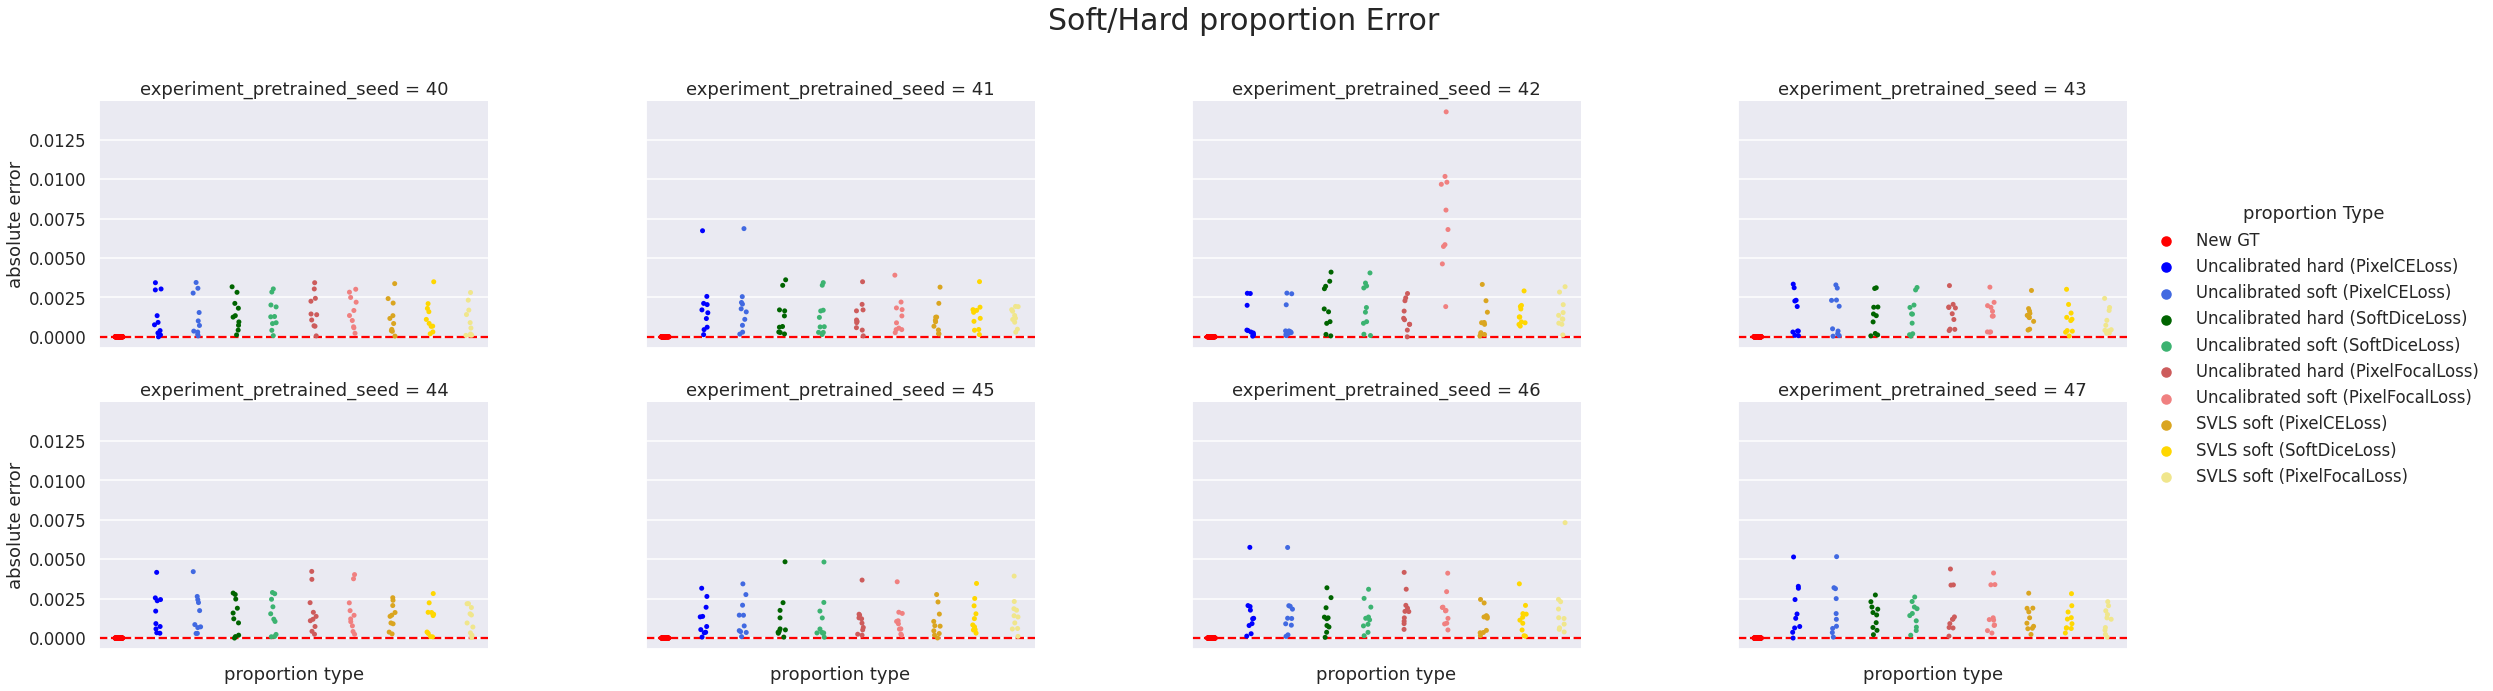

In [17]:
# Create the catplot
g = sns.catplot(
    data=melted_error_df,      # Ensure you use the 'data' parameter correctly.
    x="proportion type",
    y="absolute error",
    col="experiment_pretrained_seed",
    hue="proportion type",
    col_wrap=4,
    sharex=False,
    aspect=1.5,
    palette=custom_palette
)

# For each subplot, add a line at y = 0 to show the error.
for ax in g.axes.flat:
    ax.axhline(0, ls='--', color='red')
    ax.set_xticklabels([])

# Adjust the layout
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Soft/Hard proportion Error', fontsize=30)

# Add a legend
g.add_legend(title='proportion Type')

# Show the plot
plt.show()

In [18]:
melted_error_df

,calibrator,loss_func,data_id,experiment_pretrained_seed,gt proportion,new gt proportion,soft proportion,hard proportion,split,proportion_type,error,absolute error,proportion type
0,SVLS,PixelCELoss,patient009,45,0.019241,0.019241,0.017720,0.017334,val,soft error,-0.001521,0.001521,SVLS soft (PixelCELoss)
1,SVLS,PixelFocalLoss,patient009,47,0.019241,0.019241,0.017748,0.016968,val,new gt error,0.000000,0.000000,New GT
2,SVLS,PixelFocalLoss,patient009,42,0.019241,0.019241,0.016062,0.015686,val,new gt error,0.000000,0.000000,New GT
3,Uncalibrated,PixelFocalLoss,patient009,44,0.019241,0.019241,0.015216,0.015015,val,new gt error,0.000000,0.000000,New GT
4,Uncalibrated,PixelFocalLoss,patient009,46,0.019241,0.019241,0.015127,0.015076,val,new gt error,0.000000,0.000000,New GT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,Uncalibrated,SoftDiceLoss,patient086,45,0.009064,0.009064,0.009638,0.009644,val,hard error,0.000580,0.000580,Uncalibrated hard (SoftDiceLoss)
1196,SVLS,PixelCELoss,patient086,45,0.009064,0.009064,0.009070,0.008850,val,soft error,0.000006,0.000006,SVLS soft (PixelCELoss)
1197,Uncalibrated,SoftDiceLoss,patient086,43,0.009064,0.009064,0.009932,0.010010,val,new gt error,0.000000,0.000000,New GT
1198,Uncalibrated,SoftDiceLoss,patient086,43,0.009064,0.009064,0.009932,0.010010,val,hard error,0.000946,0.000946,Uncalibrated hard (SoftDiceLoss)


In [19]:
# We want to calculate now the average (across seeds) of the the absolute error for each method.
# That means first averaging within each seed, then averaging across seeds.
# We group by the data_id and the proportion_type.
error_per_seed = melted_error_df.groupby(["experiment_pretrained_seed", "proportion type"]).agg(
    abs_error=("absolute error", "mean"),
).reset_index()
# Rename abs_error to absolute error.
error_per_seed = error_per_seed.rename(columns={"abs_error": "absolute error"})

In [20]:
# make a table with each row being the proportion type, and the column being the abs_error mean with standard deviation in another column.
method_error_table = error_per_seed.pivot_table(
    values="absolute error",
    index="proportion type",
    columns="experiment_pretrained_seed",
    aggfunc="mean",
)
# Average across the pretrained seeds to make an average column, and then make a stdv column.
method_error_table['mean'] = method_error_table.mean(axis=1)
method_error_table['stdv'] = method_error_table.std(axis=1)
# We can drop all other columns that aren't mean and stdv
method_error_table = method_error_table[['mean', 'stdv']]

In [21]:
method_error_table.sort_values(by='mean')

experiment_pretrained_seed,mean,stdv
proportion type,,
New GT,0.000000,0.000000
SVLS soft (PixelCELoss),0.001200,0.000133
SVLS soft (SoftDiceLoss),0.001281,0.000099
SVLS soft (PixelFocalLoss),0.001300,0.000291
Uncalibrated soft (SoftDiceLoss),0.001440,0.000200
Uncalibrated hard (SoftDiceLoss),0.001447,0.000193
Uncalibrated hard (PixelCELoss),0.001488,0.000305
Uncalibrated soft (PixelCELoss),0.001504,0.000300
Uncalibrated hard (PixelFocalLoss),0.001524,0.000223


## Second, let's look at relative error.

In [22]:
proportion_df.augment(calibrator)
# Make some columns that are useful for plotting.
raw_melted_relative_df = prepare_error_df(
    proportion_df, 
    groupby_keys=[
        "calibrator",
        "loss_func",
        "data_id", 
        "experiment_pretrained_seed", 
        "gt proportion", 
        "new gt proportion",
        "soft proportion", 
        "hard proportion",
        "split",
    ],
    value_vars=["new gt relative error", "soft relative error", "hard relative error"],
    var_name="proportion_type",
    value_name="relative error"
)
# Process the proportion types.
melted_relative_df = process_method_names(raw_melted_relative_df, value_name="relative error")

In [23]:
melted_relative_df['proportion type'].unique()

array(['SVLS soft (PixelCELoss)', 'New GT',
       'Uncalibrated soft (SoftDiceLoss)', 'SVLS soft (SoftDiceLoss)',
       'Uncalibrated soft (PixelCELoss)',
       'Uncalibrated hard (SoftDiceLoss)',
       'Uncalibrated hard (PixelCELoss)',
       'Uncalibrated hard (PixelFocalLoss)', 'SVLS soft (PixelFocalLoss)',
       'Uncalibrated soft (PixelFocalLoss)'], dtype=object)

In [24]:
# Finally, we want to change the order that the methods appear in.
melted_error_df['proportion type'] = melted_error_df['proportion type'].astype('category')
melted_error_df['proportion type'] = melted_error_df['proportion type'].cat.reorder_categories([
    'New GT',
    'Uncalibrated hard (PixelCELoss)',
    'Uncalibrated soft (PixelCELoss)',
    'Uncalibrated hard (SoftDiceLoss)',
    'Uncalibrated soft (SoftDiceLoss)',
    'Uncalibrated hard (PixelFocalLoss)',
    'Uncalibrated soft (PixelFocalLoss)',
    'SVLS soft (PixelCELoss)',
    'SVLS soft (SoftDiceLoss)',
    'SVLS soft (PixelFocalLoss)',
])

# Custom palette dictionary
custom_palette = {
    'New GT': 'red',
    'Uncalibrated hard (PixelCELoss)': 'blue',
    'Uncalibrated soft (PixelCELoss)': 'royalblue',
    'Uncalibrated hard (SoftDiceLoss)': 'darkgreen',
    'Uncalibrated soft (SoftDiceLoss)': 'mediumseagreen',
    'Uncalibrated hard (PixelFocalLoss)': 'indianred',
    'Uncalibrated soft (PixelFocalLoss)': 'lightcoral',
    'SVLS soft (PixelCELoss)': 'goldenrod',
    'SVLS soft (SoftDiceLoss)': 'gold',
    'SVLS soft (PixelFocalLoss)': 'khaki',
}

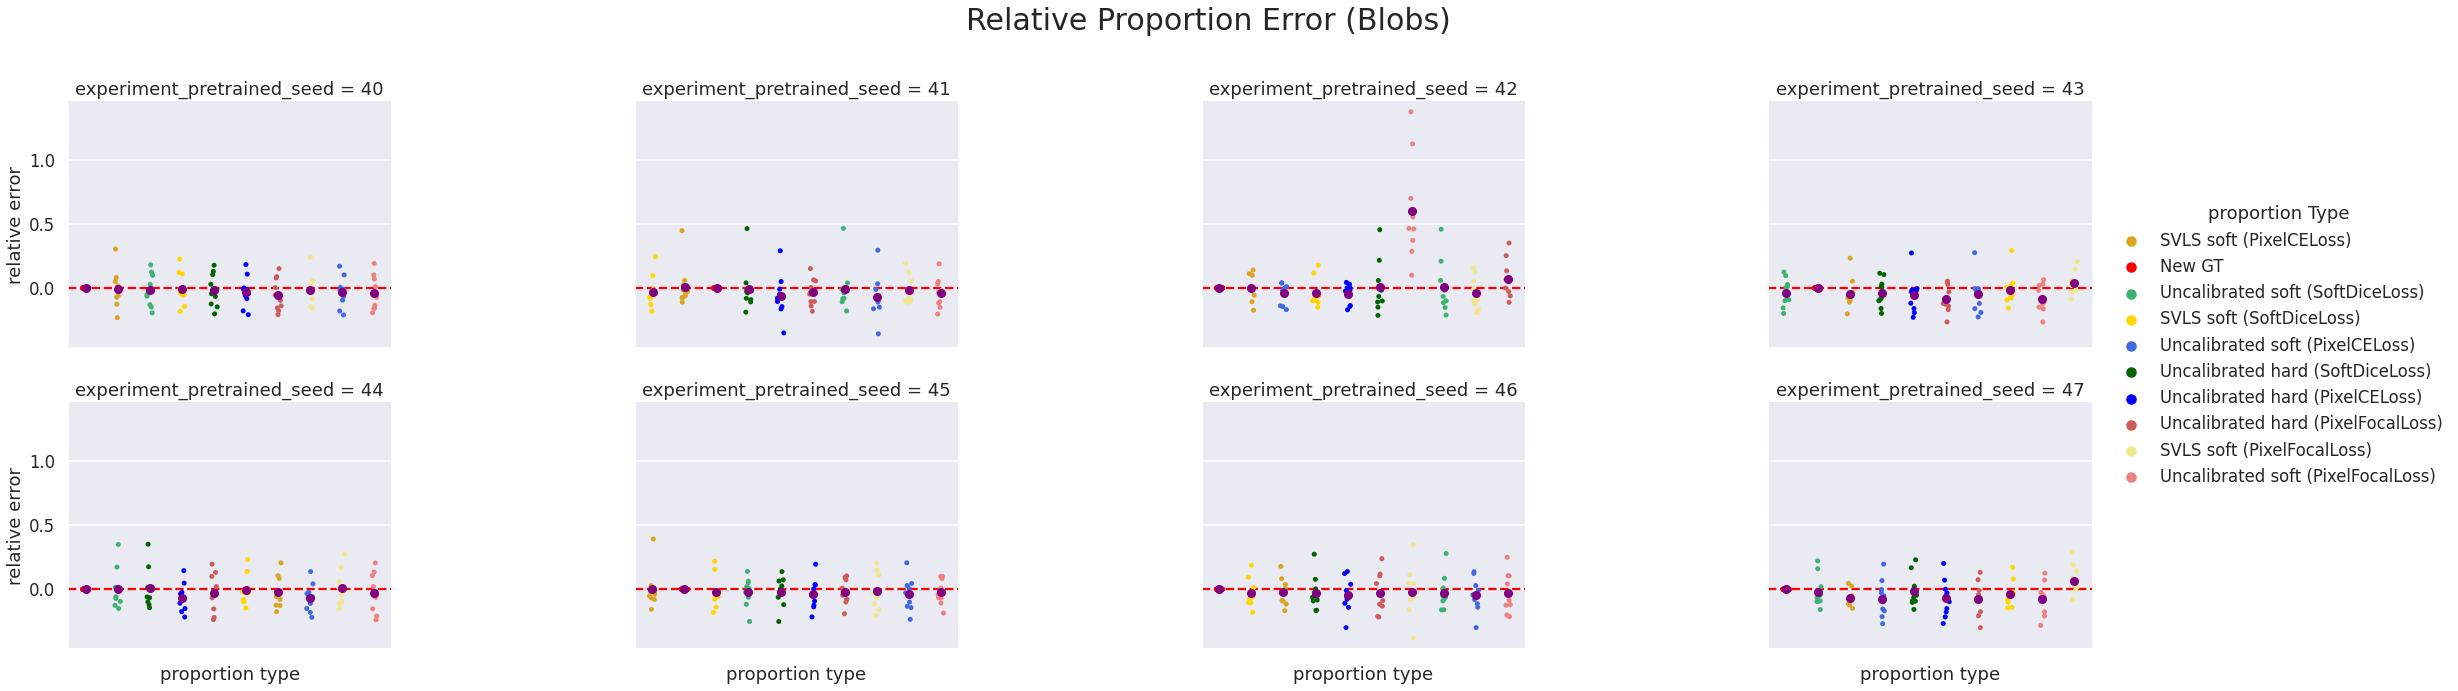

In [25]:
# Create the catplot
g = sns.catplot(
    data=melted_relative_df,      # Ensure you use the 'data' parameter correctly.
    x="proportion type",
    y="relative error",
    col="experiment_pretrained_seed",
    hue="proportion type",
    col_wrap=4,
    sharex=False,
    aspect=1.5,
    palette=custom_palette
)

# Calculate the means
means = melted_relative_df.groupby(['experiment_pretrained_seed', 'proportion type'])['relative error'].mean().reset_index()

# For each subplot make a line at y = 0 to show the error and add the means
for ax in g.axes.flat:
    ax.axhline(0.0, ls='--', color='red')
    ax.set_xticklabels([])
    
    # Get the corresponding seed for the current subplot
    seed = ax.get_title().split(' = ')[-1]
    
    # Filter means for the current subplot
    seed_means = means[means['experiment_pretrained_seed'] == int(seed)]
    
    # Plot a purple circle at the mean position
    for _, row in seed_means.iterrows():
        ax.plot(row['proportion type'], row['relative error'], 'o', color='purple', markersize=8, zorder=10)

# Adjust the layout
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Relative Proportion Error (Blobs)', fontsize=30)

# Add a legend
g.add_legend(title='proportion Type')

# Show the plot
plt.show()

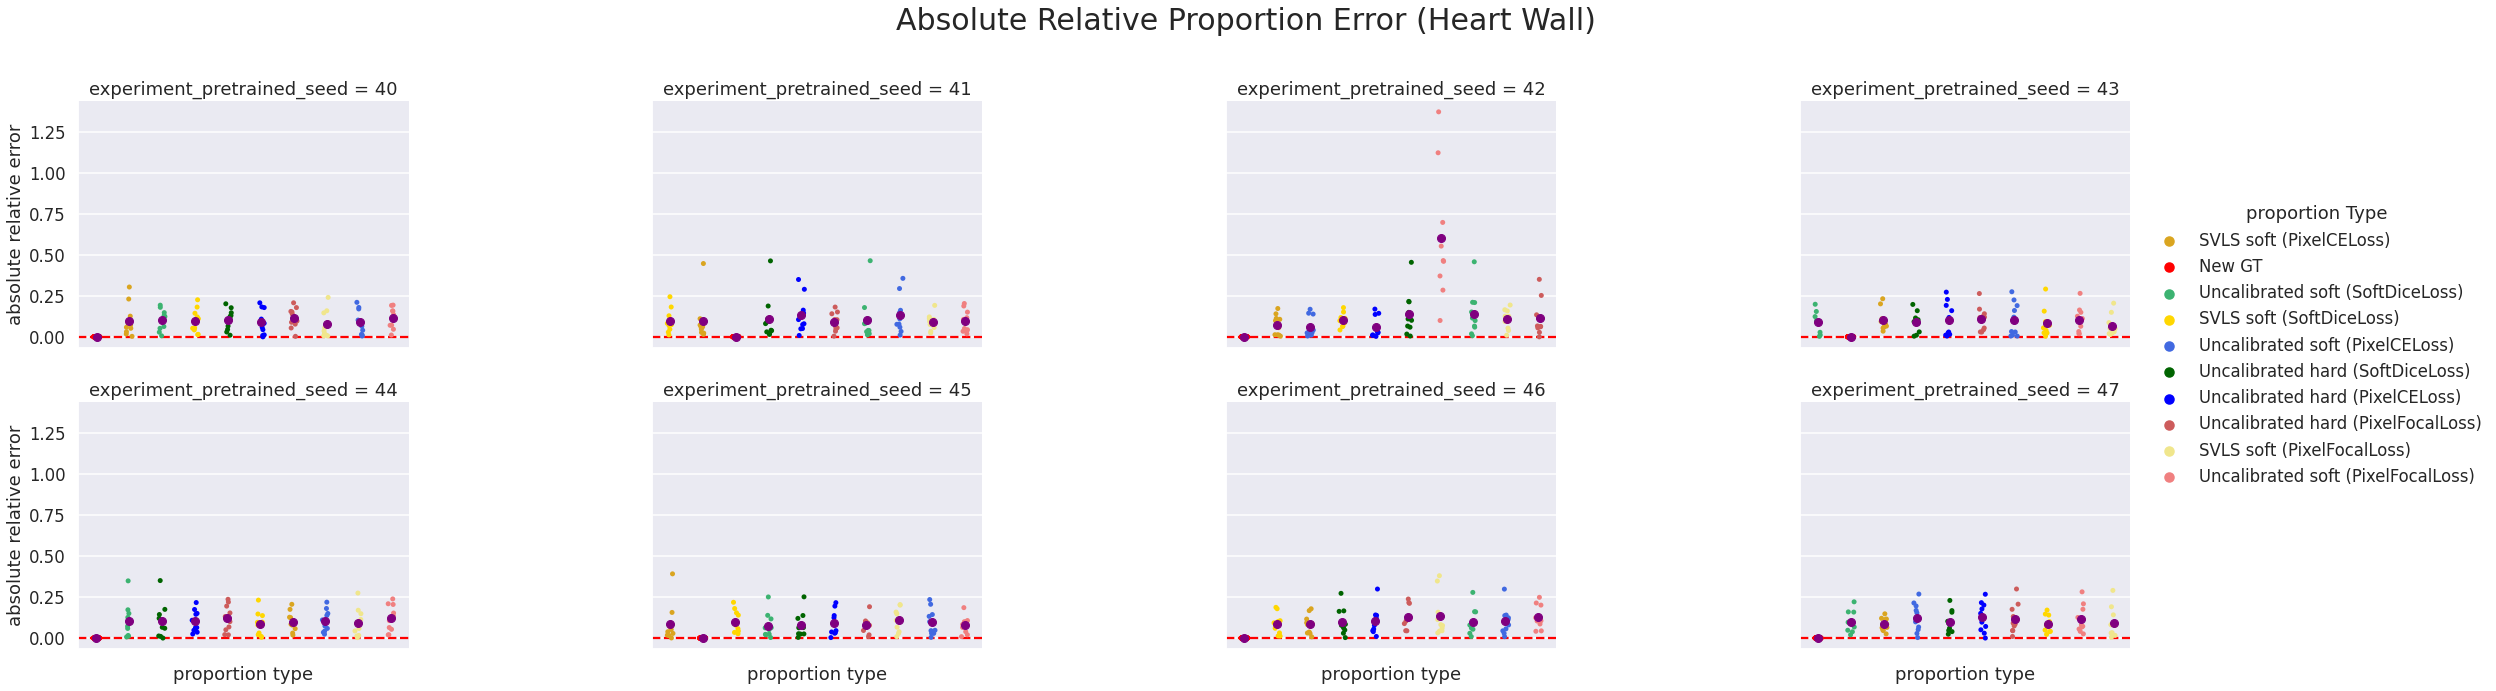

In [26]:
# Create the catplot
g = sns.catplot(
    data=melted_relative_df,      # Ensure you use the 'data' parameter correctly.
    x="proportion type",
    y="absolute relative error",
    col="experiment_pretrained_seed",
    hue="proportion type",
    col_wrap=4,
    sharex=False,
    aspect=1.5,
    palette=custom_palette
)

# Calculate the means
means = melted_relative_df.groupby(['experiment_pretrained_seed', 'proportion type'])['absolute relative error'].mean().reset_index()

# For each subplot make a line at y = 0 to show the error and add the means
for ax in g.axes.flat:
    ax.axhline(0.0, ls='--', color='red')
    ax.set_xticklabels([])
    
    # Get the corresponding seed for the current subplot
    seed = ax.get_title().split(' = ')[-1]
    
    # Filter means for the current subplot
    seed_means = means[means['experiment_pretrained_seed'] == int(seed)]
    
    # Plot a purple circle at the mean position
    for _, row in seed_means.iterrows():
        ax.plot(row['proportion type'], row['absolute relative error'], 'o', color='purple', markersize=8, zorder=10)

# Adjust the layout
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Absolute Relative Proportion Error (Heart Wall)', fontsize=30)

# Add a legend
g.add_legend(title='proportion Type')

# Show the plot
plt.show()

# Let's look at this averaged over seeds.

In [27]:
# We want to calculate now the average (across seeds) of the the absolute error for each method.
# That means first averaging within each seed, then averaging across seeds.
# We group by the data_id and the proportion_type.
relative_per_seed = melted_relative_df.groupby(["experiment_pretrained_seed", "proportion type"]).agg(
    abs_relative_error=("absolute relative error", "mean"),
).reset_index()
# Rename abs_error to absolute error.
relative_per_seed = relative_per_seed.rename(columns={"abs_relative_error": "absolute relative error"})

In [28]:
# make a table with each row being the proportion type, and the column being the abs_error mean with standard deviation in another column.
method_relative_table = relative_per_seed.pivot_table(
    values="absolute relative error",
    index="proportion type",
    columns="experiment_pretrained_seed",
    aggfunc="mean",
)
# Average across the pretrained seeds to make an average column, and then make a stdv column.
method_relative_table['mean'] = method_relative_table.mean(axis=1)
method_relative_table['stdv'] = method_relative_table.std(axis=1)
# We can drop all other columns that aren't mean and stdv
method_relative_table = method_relative_table[['mean', 'stdv']]

In [29]:
method_relative_table.sort_values(by='mean')

experiment_pretrained_seed,mean,stdv
proportion type,,
New GT,0.000000,0.000000
SVLS soft (PixelCELoss),0.089437,0.009458
SVLS soft (SoftDiceLoss),0.091554,0.006348
SVLS soft (PixelFocalLoss),0.096502,0.018692
Uncalibrated hard (PixelCELoss),0.101044,0.021036
Uncalibrated soft (PixelCELoss),0.101948,0.020558
Uncalibrated soft (SoftDiceLoss),0.102183,0.016937
Uncalibrated hard (SoftDiceLoss),0.102789,0.016160
Uncalibrated hard (PixelFocalLoss),0.109000,0.015815


# And lets look at this over Data_ids.

In [30]:
# We want to calculate now the average (across seeds) of the the absolute error for each method.
# That means first averaging within each seed, then averaging across seeds.
# We group by the data_id and the proportion_type.
relative_per_dataid = melted_relative_df.groupby(["data_id", "proportion type"]).agg(
    abs_relative_error=("absolute relative error", "mean"),
).reset_index()
# Rename abs_error to absolute error.
relative_per_dataid = relative_per_dataid.rename(columns={"abs_relative_error": "absolute relative error"})

In [31]:
# make a table with each row being the proportion type, and the column being the abs_error mean with standard deviation in another column.
method_relative_table_dataid = relative_per_dataid.pivot_table(
    values="absolute relative error",
    index="proportion type",
    columns="data_id",
    aggfunc="mean",
)
# Average across the pretrained seeds to make an average column, and then make a stdv column.
method_relative_table_dataid['mean'] = method_relative_table_dataid.mean(axis=1)
method_relative_table_dataid['stdv'] = method_relative_table_dataid.std(axis=1)
# We can drop all other columns that aren't mean and stdv
method_relative_table_dataid = method_relative_table_dataid[['mean', 'stdv']]

In [32]:
method_relative_table_dataid.sort_values(by='mean')

data_id,mean,stdv
proportion type,,
New GT,0.000000,0.000000
SVLS soft (PixelCELoss),0.089437,0.062699
SVLS soft (SoftDiceLoss),0.091554,0.056933
SVLS soft (PixelFocalLoss),0.096502,0.059902
Uncalibrated hard (PixelCELoss),0.101044,0.061104
Uncalibrated soft (PixelCELoss),0.101948,0.062019
Uncalibrated soft (SoftDiceLoss),0.102183,0.066450
Uncalibrated hard (SoftDiceLoss),0.102789,0.067458
Uncalibrated hard (PixelFocalLoss),0.109000,0.051097


# Finally, we want to look at the Dice score and Image ECE of all three methods as we are arguing that Image ECE is what we should care about.

In [33]:
inference_df

,pred_hash,image_metric,metric_score,batch_idx,split,data_cfg_opt,label_idx,gt_proportion,data_id,gt_volume,...,model_convs_per_block,model_filters,model_in_channels,model_out_channels,model_pred_label,model_pretrained_exp_root,model_pretrained_select_metric,loss_func_alpha,loss_func_gamma,loss_func
0,-3806889775134162636,Dice,0.874433,0,val,split:val,-1,0.020447,patient025,335.00,...,3,"(64, 64, 64, 64, 64)",1,1,0,/storage/vbutoi/scratch/ESE/training/07_09_24_...,val-dice_score,None,None,PixelCELoss
1,-3806889775134162636,HD95,3.162278,0,val,split:val,-1,0.020447,patient025,335.00,...,3,"(64, 64, 64, 64, 64)",1,1,0,/storage/vbutoi/scratch/ESE/training/07_09_24_...,val-dice_score,None,None,PixelCELoss
2,-3806889775134162636,BoundaryIOU,0.100304,0,val,split:val,-1,0.020447,patient025,335.00,...,3,"(64, 64, 64, 64, 64)",1,1,0,/storage/vbutoi/scratch/ESE/training/07_09_24_...,val-dice_score,None,None,PixelCELoss
3,-3806889775134162636,SoftVolumeError,-4.331360,0,val,split:val,-1,0.020447,patient025,335.00,...,3,"(64, 64, 64, 64, 64)",1,1,0,/storage/vbutoi/scratch/ESE/training/07_09_24_...,val-dice_score,None,None,PixelCELoss
4,-3806889775134162636,HardVolumeError,-6.000000,0,val,split:val,-1,0.020447,patient025,335.00,...,3,"(64, 64, 64, 64, 64)",1,1,0,/storage/vbutoi/scratch/ESE/training/07_09_24_...,val-dice_score,None,None,PixelCELoss
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10055,2036055789712870480,Dice Loss,0.082707,0,val,split:val,-1,0.012451,patient067,204.00,...,3,"(64, 64, 64, 64, 64)",1,1,0,/storage/vbutoi/scratch/ESE/training/07_11_24_...,val-dice_score,0.25,2.0,PixelFocalLoss
10056,-8371515824335461705,Dice Loss,0.190298,0,val,split:val,-1,0.016312,patient014,267.25,...,3,"(64, 64, 64, 64, 64)",1,1,0,/storage/vbutoi/scratch/ESE/training/07_11_24_...,val-dice_score,0.25,2.0,PixelFocalLoss
10057,4317908027346413397,Dice Loss,0.142191,0,val,split:val,-1,0.014633,patient058,239.75,...,3,"(64, 64, 64, 64, 64)",1,1,0,/storage/vbutoi/scratch/ESE/training/07_11_24_...,val-dice_score,0.25,2.0,PixelFocalLoss
10058,246847975478600138,Dice Loss,0.103586,1,val,split:val,-1,0.015747,patient056,258.00,...,3,"(64, 64, 64, 64, 64)",1,1,0,/storage/vbutoi/scratch/ESE/training/07_11_24_...,val-dice_score,0.25,2.0,PixelFocalLoss


In [34]:
# Get the relevant columns for looking at the Dice score and Image ECE
metric_cols = [
    "data_id",
    "loss_func",
    "experiment_pretrained_seed",
    "model_pretrained_exp_root",
    "split",
    "image_metric",
    "metric_score"
]
# Take these columns of the inference_df, drop other columns and delete duplicate rows.
metric_df = inference_df[metric_cols].drop_duplicates().reset_index(drop=True)
metric_df.augment(calibrator)
# Drop the 'pretrained_exp_root column
metric_df = metric_df.drop(columns=["model_pretrained_exp_root"])

In [35]:
def train_method(calibrator, loss_func):
    return calibrator + f" ({loss_func})"

metric_df.augment(train_method)

In [36]:
metric_df

,data_id,loss_func,experiment_pretrained_seed,split,image_metric,metric_score,calibrator,train_method
0,patient025,PixelCELoss,42,val,Dice,0.874433,SVLS,SVLS (PixelCELoss)
1,patient025,PixelCELoss,42,val,HD95,3.162278,SVLS,SVLS (PixelCELoss)
2,patient025,PixelCELoss,42,val,BoundaryIOU,0.100304,SVLS,SVLS (PixelCELoss)
3,patient025,PixelCELoss,42,val,SoftVolumeError,-4.331360,SVLS,SVLS (PixelCELoss)
4,patient025,PixelCELoss,42,val,HardVolumeError,-6.000000,SVLS,SVLS (PixelCELoss)
...,...,...,...,...,...,...,...,...
3355,patient067,PixelFocalLoss,40,val,Dice Loss,0.082707,SVLS,SVLS (PixelFocalLoss)
3356,patient014,PixelFocalLoss,40,val,Dice Loss,0.190298,SVLS,SVLS (PixelFocalLoss)
3357,patient058,PixelFocalLoss,40,val,Dice Loss,0.142191,SVLS,SVLS (PixelFocalLoss)
3358,patient056,PixelFocalLoss,40,val,Dice Loss,0.103586,SVLS,SVLS (PixelFocalLoss)


In [37]:
# Groupby the pretrained_seed and image_metrics, and calibrator, and take the mean of the metric_score.
metric_per_seed = metric_df.groupby(["experiment_pretrained_seed", "loss_func", "image_metric", "train_method"]).agg(
    metric_score=("metric_score", "mean"),
).reset_index()

In [38]:
# Finally, we want to change the order that the methods appear in.
metric_per_seed['train_method'] = metric_per_seed['train_method'].astype('category')
metric_per_seed['train_method'] = metric_per_seed['train_method'].cat.reorder_categories([
    'Uncalibrated (PixelCELoss)',
    'Uncalibrated (SoftDiceLoss)',
    'Uncalibrated (PixelFocalLoss)',
    'SVLS (PixelCELoss)',
    'SVLS (SoftDiceLoss)',
    'SVLS (PixelFocalLoss)',
])

In [39]:
result = metric_per_seed.groupby(['train_method', 'image_metric']).agg(
    mean_metric_score=('metric_score', 'mean'),
    std_metric_score=('metric_score', 'std')
).reset_index()

# Pivot the table to have one row for each train_method
result = result.pivot(
    index='train_method', 
    columns='image_metric', 
    values=[
        'mean_metric_score', 
        'std_metric_score'
    ]
)

# Flatten the column multi-index
result.columns = ['_'.join(col).strip() for col in result.columns.values]
result = result.reset_index()

In [40]:
result

,train_method,mean_metric_score_BoundaryIOU,mean_metric_score_Dice,mean_metric_score_Dice Loss,mean_metric_score_HD95,mean_metric_score_HardVolumeError,mean_metric_score_Image_ECE,mean_metric_score_SoftVolumeError,std_metric_score_BoundaryIOU,std_metric_score_Dice,std_metric_score_Dice Loss,std_metric_score_HD95,std_metric_score_HardVolumeError,std_metric_score_Image_ECE,std_metric_score_SoftVolumeError
0,Uncalibrated (PixelCELoss),0.016059,0.807291,0.192709,3.364902,-15.6125,0.007437,-16.081912,0.000555,0.012562,0.012562,0.105162,4.121178,0.000210,4.116685
1,Uncalibrated (SoftDiceLoss),0.016900,0.823186,0.176814,3.310880,-8.8875,0.007283,-8.959086,0.000801,0.008581,0.008581,0.141469,2.871504,0.000196,2.562673
2,Uncalibrated (PixelFocalLoss),0.016257,0.817848,0.182152,3.310837,-11.3625,0.006733,3.411111,0.000753,0.011025,0.011025,0.184663,9.850009,0.000937,49.657922
3,SVLS (PixelCELoss),0.016307,0.821021,0.178979,3.248838,-11.6750,0.002280,-9.079407,0.000515,0.005452,0.005452,0.073437,5.077964,0.000141,5.057667
4,SVLS (SoftDiceLoss),0.016507,0.835706,0.164294,3.183926,-10.9125,0.002061,-9.806634,0.000536,0.007471,0.007471,0.059593,2.772538,0.000097,2.471862
5,SVLS (PixelFocalLoss),0.016334,0.818517,0.181483,3.381598,-12.2750,0.001979,-5.054444,0.000642,0.013652,0.013652,0.207396,7.093861,0.000281,9.245945


In [41]:
# Get all the of the columns that are 'calibrator' and have 'Dice_Loss' in them
dice_cols = [col for col in result.columns if 'Dice Loss' in col or 'train_method' in col]
dice_result = result[dice_cols]

In [42]:
dice_result.sort_values(by='mean_metric_score_Dice Loss')

,train_method,mean_metric_score_Dice Loss,std_metric_score_Dice Loss
4,SVLS (SoftDiceLoss),0.164294,0.007471
1,Uncalibrated (SoftDiceLoss),0.176814,0.008581
3,SVLS (PixelCELoss),0.178979,0.005452
5,SVLS (PixelFocalLoss),0.181483,0.013652
2,Uncalibrated (PixelFocalLoss),0.182152,0.011025
0,Uncalibrated (PixelCELoss),0.192709,0.012562


In [43]:
# Get all the of the columns that are 'calibrator' and have 'Image_ECE' in them
image_ece_cols = [col for col in result.columns if 'Image_ECE' in col or 'train_method' in col]
ece_result = result[image_ece_cols]

In [44]:
ece_result.sort_values(by='mean_metric_score_Image_ECE')

,train_method,mean_metric_score_Image_ECE,std_metric_score_Image_ECE
5,SVLS (PixelFocalLoss),0.001979,0.000281
4,SVLS (SoftDiceLoss),0.002061,0.000097
3,SVLS (PixelCELoss),0.002280,0.000141
2,Uncalibrated (PixelFocalLoss),0.006733,0.000937
1,Uncalibrated (SoftDiceLoss),0.007283,0.000196
0,Uncalibrated (PixelCELoss),0.007437,0.000210
